## **Visualizing Activation Heatmaps**


---

It can be very useful to visualize what the convnet values when it does a prediction, as it allows us to see whether our model is on track, as well as what features it finds important. For example, in determining whether an image is human or not, our model may find that the face is a determining factor.

To visualize the heatmap, we will use a technique called Grad-CAM (Gradient Class Activation Map). The idea behind it is quite simple. To find the importance of a certain class in our model, we simply take its gradient with resepct to the final convolutional layer, and then weigh it against the output of this layer.

Francois Chollet, author of Deep Learning with Python and the creator of Keras, says, "one way to understand this trick is that we are weighting a spatial map of how intensely the input image activates different channels by how important each channel is with regard to the class, resulting in a spatial map of how intensely the input image activates the class."

This is the layout of using Grad-CAM:

    1) Compute the model output and last convolutional layer output for the image.
    2) Find the index of the winning class in the model output.
    3) Compute the gradient of the winning class with resepct to the last convolutional layer.
    3) Average this, then weigh it with the last convolutional layer (multiply them).
    4) Normalize between 0 and 1 for visualization
    5) Convert to RGB and layer it over the original image.


Let's start by importing what we need.

In [0]:
%tensorflow_version 2.x # Used in Google Colab

TensorFlow 2.x selected.


In [0]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow # cv2.imshow does not work on Google Colab notebooks, which is why we are using cv2_imshow instead

Now let's load the model. Since the goal of this tutorial is how to generate an activation heatmap, we will just use the Inception V3 model, which is already pretrained. It is trained to classify over many different classes.

This model takes in a ```299x299``` image. According to [Sik-Ho Tsang](https://medium.com/@sh.tsang/review-inception-v3-1st-runner-up-image-classification-in-ilsvrc-2015-17915421f77c), at "42 layers deep, the computation cost is only about 2.5 higher than that of GoogLeNet, and much more efficient than that of VGGNet." It is a very deep network, which is why it is provided as a pretrained model in the keras library. The following will print out the architecure of the model - although there are many computations, we are only looking for the final convolutional layer, which lies near the end of the list.

In [0]:
model = InceptionV3(weights='imagenet')

model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

As we can see, the final convolutional layer is ```conv2d_93``` for this model. Now let's load some images to test and see what it looks like. First, we'll test on an image of an indian elephant.

In [0]:
!wget https://indiasendangered.com/wp-content/uploads/2011/09/elephant.jpg
!wget https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/12234558/Chinook-On-White-03.jpg
!wget https://icatcare.org/app/uploads/2018/07/Thinking-of-getting-a-cat.png

--2019-12-25 04:59:32--  https://indiasendangered.com/wp-content/uploads/2011/09/elephant.jpg
Resolving indiasendangered.com (indiasendangered.com)... 199.79.62.149
Connecting to indiasendangered.com (indiasendangered.com)|199.79.62.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 137242 (134K) [image/jpeg]
Saving to: ‘elephant.jpg.1’

elephant.jpg.1      100%[===================>] 134.03K  --.-KB/s    in 0.1s    

2019-12-25 04:59:32 (1.36 MB/s) - ‘elephant.jpg.1’ saved [137242/137242]

--2019-12-25 04:59:33--  https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/12234558/Chinook-On-White-03.jpg
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.131.101
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.131.101|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25761 (25K) [image/jpeg]
Saving to: ‘Chinook-On-White-03.jpg.1’

Chinook-On-White-03 100%[===================>]  25.16K  --.-KB/s    in 0.03s 

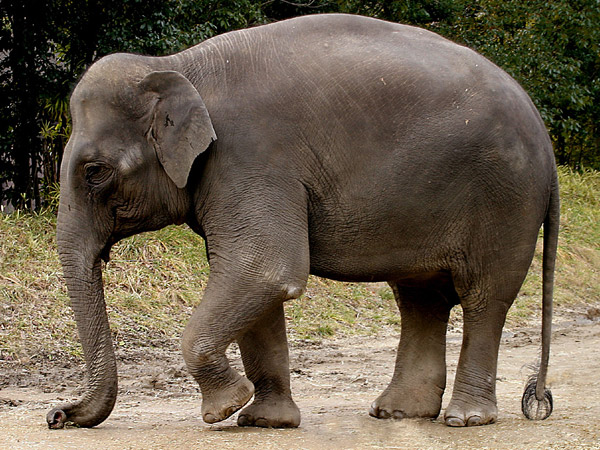

In [0]:
ORIGINAL = 'elephant.jpg'

DIM = 299

img = image.load_img(ORIGINAL, target_size=(DIM, DIM))

cv2_imshow(cv2.imread(ORIGINAL)) # Visualize image

Now let's preprocess the input to feed into our model. We will need to add a dimension to our image and preprocess it as well, using the ```preprocess_input``` model given to use by ```tf.keras```

In [0]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
print(decode_predictions(preds))

[[('n02504013', 'Indian_elephant', 0.96241), ('n01871265', 'tusker', 0.015191137), ('n02504458', 'African_elephant', 0.00047370436), ('n04346328', 'stupa', 0.00033354986), ('n01694178', 'African_chameleon', 0.00029568528)]]


As we can see, the above picture was predicted as being ```Indian_elephant``` with a probability of ```.962```. 

## **Grad-CAM**



---

Now we can start the Grad-CAM process. To start, we will need to define a ```tf.GradientTape```, so tensorflow can calculate the gradients (this is a new feature in TF 2). Next, we will get the final convolutional layer, which is the aforementioned ```conv2d_93```. Next, we will create a model (which behaves as a function) that takes as input an image (```model.inputs```) and outputs a list of the output of the model, and the output of the final convolutional layer.

Next, we will calculate the class output by indexing the model output with the winning class (```np.argmax``` finds the index of the greatest value in the input). With this info, we can calculate the gradient between the class output and the convolutional layer output, which we will then average among all the axes. Lastly, we will multiply the two to get our final heatmap. 

In [0]:
with tf.GradientTape() as tape:
  last_conv_layer = model.get_layer('conv2d_93')
  iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
  model_out, last_conv_layer = iterate(x)
  class_out = model_out[:, np.argmax(model_out[0])]
  grads = tape.gradient(class_out, last_conv_layer)
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  
heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)

Now let's visualize our heatmap. To do this, we will bring all the values between 0 and 1 and also reshape it to be an ```8x8``` array.

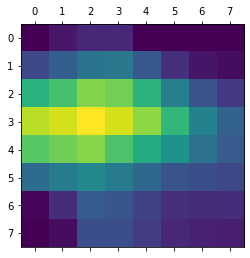

In [0]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
heatmap = heatmap.reshape((8, 8))
plt.matshow(heatmap)
plt.show()

Now let's cover the image with the heatmap. First, we load the image. 

In [0]:
img = cv2.imread(ORIGINAL)

Next, we resize the heatmap to match the images shape, so that it can properly impose it. Next, we use ```cv2.applyColorMap``` to apply the heatmap to our image (we multiply by ```255``` to convert it into RGB form). We also multiply our heatmap by an intensity of our choosing, depending on how much we want our heatmap to cover our image.

In [0]:
INTENSITY = 0.5

heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

img = heatmap * INTENSITY + img

Now let's view our original image and our new image with the activation heatmaps.

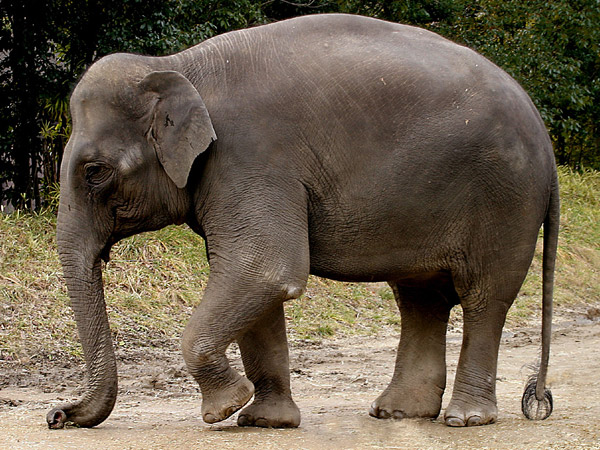

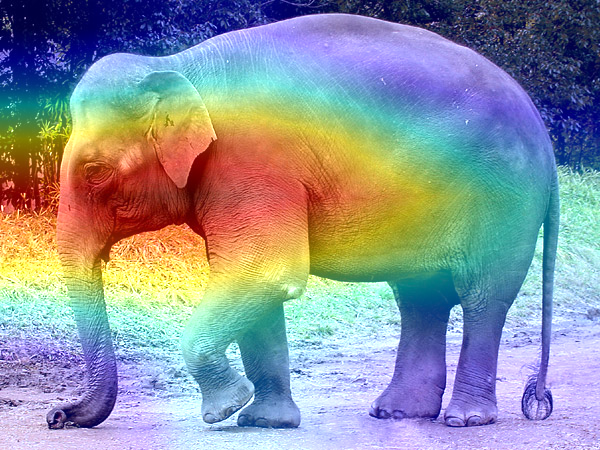

In [0]:
cv2_imshow(cv2.imread(ORIGINAL))
cv2_imshow(img)

As we can see, the elephant's head activated our model more than the rest of the image. 

Let's try it out on different images to see if it works. First, let's compile all of our code into a function so it's easy to use.

[[('n02099712', 'Labrador_retriever', 0.2964751), ('n02109525', 'Saint_Bernard', 0.07349995), ('n02105162', 'malinois', 0.06864362), ('n02108422', 'bull_mastiff', 0.06427535), ('n02099601', 'golden_retriever', 0.054180294)]]


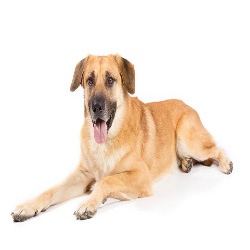

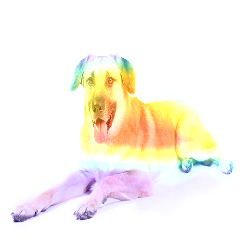

[[('n02123045', 'tabby', 0.7996945), ('n02123159', 'tiger_cat', 0.10785821), ('n02124075', 'Egyptian_cat', 0.052523103), ('n02127052', 'lynx', 0.0016047976), ('n04589890', 'window_screen', 0.0004530022)]]


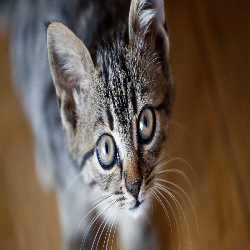

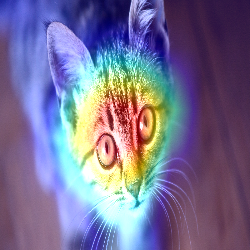

In [0]:
def gradCAM(orig, intensity=0.5, res=250):
  img = image.load_img(orig, target_size=(DIM, DIM))

  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  preds = model.predict(x)
  print(decode_predictions(preds))

  with tf.GradientTape() as tape:
    last_conv_layer = model.get_layer('conv2d_93')
    iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
    model_out, last_conv_layer = iterate(x)
    class_out = model_out[:, np.argmax(model_out[0])]
    grads = tape.gradient(class_out, last_conv_layer)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    
  heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  heatmap = heatmap.reshape((8, 8))

  img = cv2.imread(orig)

  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

  heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

  img = heatmap * intensity + img

  cv2_imshow(cv2.resize(cv2.imread(orig), (res, res)))
  cv2_imshow(cv2.resize(img, (res, res)))

gradCAM("Chinook-On-White-03.jpg")
gradCAM("Thinking-of-getting-a-cat.png")

---

# References

https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.4-visualizing-what-convnets-learn.ipynb
https://stackoverflow.com/questions/58322147/how-to-generate-cnn-heatmaps-using-built-in-keras-in-tf2-0-tf-keras
